# Classification algorithm

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import tarfile
import urllib 
import pandas as pd
import seaborn as sns
 
# Use pandas to retrieve data file
url = '' # use to fetch data file each time
cancer = pd.read_csv("data.csv",index_col=0)
cancer.head()
cancer.info()
#cancer.drop(cancer.axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

# Split into training, test set 

##### Use ```sklearn.model_selection.train_test_split``` or do stratified sampling with ```StratifiedShuffleSplit```?

In [26]:
from sklearn.model_selection import train_test_split
#from sklearn.base import clone 

X_train, X_test, y_train, y_test = train_test_split(cancer.copy().drop("diagnosis",axis=1), cancer.copy().diagnosis,\
                                                    test_size=0.3, shuffle=True, random_state=1)
#train_set, test_test = StratifiedShuffleSplit(df, test_size=0.25, random_state=42)


##### Use ```sklearn.model_selection.train_test_split``` or do stratified sampling with ```StratifiedShuffleSplit```?


#### Stochastic Gradient Descent classifier ```sklearn.linear_model.SGDClassifier```: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

Set ```loss="hinge"``` fits a linear SVC (```sklearn.svm.LinearSVC```) but doesn't allow for probability estimates. Use ```loss="log"``` or ```"modified_huber"```

In [27]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='modified_huber',max_iter=1e5,tol=1.0e-3,\
                   validation_fraction=0.2,early_stopping=False,random_state=1)

#### SGD is sensitive to feature scaling... scale so features have mean=0 and variance=0 using ```StandardScaler()```

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Fit SGD classifier to training set, and do cross-validation:
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [29]:
clf.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=100000.0, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.2, verbose=0, warm_start=False)

In [30]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve,precision_score,recall_score,f1_score,\
            average_precision_score,precision_recall_curve,confusion_matrix 

# First find scores from fitting (no cv)
scores = clf.decision_function( X_train_scaled)
# use CV for better evaluation
cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
y_scores = cross_val_predict(clf, X_train_scaled, y_train, cv=3, method='decision_function')
y_train_pred = cross_val_predict(clf, X_train_scaled, y_train, cv=3)
Cij = confusion_matrix( y_train, y_train_pred)
fpr,tpr,thresh = roc_curve( y_train, y_scores, pos_label='M')
precision,recall,thresholds = precision_recall_curve( y_train, y_scores, pos_label='M')

Training cross-validation scores:  [0.93233083 0.96240602 0.95454545]
Training CV confusion matrix:  [[238  11]
 [  9 140]]


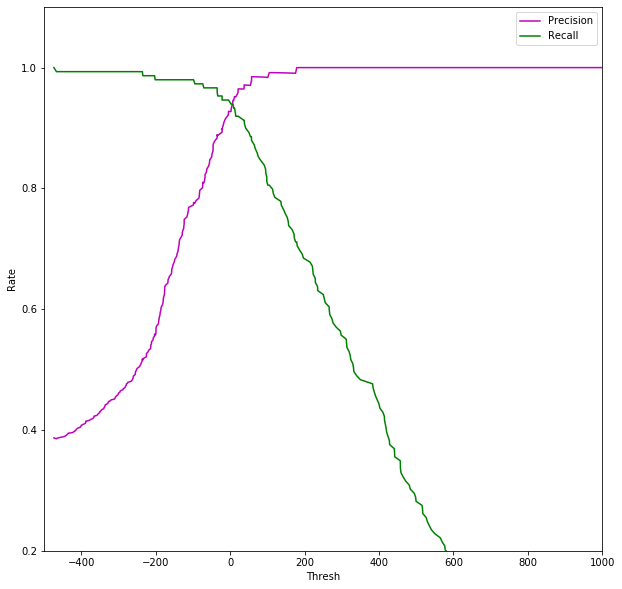

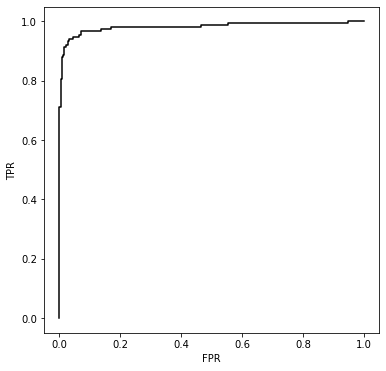

In [31]:
#print("Avg score (train, test): ",score,clf.score)
print("Training cross-validation scores: ",cv_scores)
print("Training CV confusion matrix: ",Cij)
#print("Test scores: ",y_scores, scores)
# print("Test confusion matrix: ",Cij_test)

plt.figure(figsize=(10,10))
plt.plot(thresholds,precision[:-1],'m-')
plt.plot(thresholds,recall[:-1],'g-')
plt.xlabel("Thresh")
plt.ylabel("Rate")
#plt.xscale('log')
plt.xlim(-500,1000)
plt.ylim(0.2,1.1)
plt.legend(["Precision","Recall"])
#plt.annotate("Train set CV",xy=(0.6,0.6),xycoords="axes fraction")
plt.show()
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'k-')
#plt.xscale('log')
plt.xlabel("FPR")
plt.ylabel("TPR")
# plt.plot(thresh,tpr,'g-')
# plt.annotate("Train set CV",xy=(0.6,0.6),xycoords="axes fraction")
plt.show()
# plt.figure()
# plt.plot(thresh_test,fpr_test,'m-')
# plt.plot(thresh_test,tpr_test,'g-')
# plt.annotate("Test set",xy=(0.6,0.6),xycoords="axes fraction")
# plt.xlabel("FPR")
# plt.ylabel("TPR")
# plt.show()

### QUESTION: how do you predict probability of classification?

### Evaluate classifier using the test set

In [32]:
y_test_pred = clf.predict(X_test_scaled)
y_test_scores = clf.decision_function(X_test_scaled)
accuracy_test = clf.score( X_test_scaled, y_test)
#y_test_pred = cross_val_predict(clf, X_test_scaled, y_test, cv=3)
Cij_test = confusion_matrix( y_test, y_test_pred)
#cv_test_scores = cross_val_score(clf, X_test_scaled, y_test, cv=3, scoring='accuracy')
#y_test_scores = cross_val_predict(clf, X_test_scaled, y_test, cv=3, method='decision_function')
#y_test_pred = cross_val_predict(clf, X_test_scaled, y_test, cv=3)
#Cij_test = confusion_matrix( y_test, y_test_pred)
#fpr,tpr,thresh = roc_curve( y_test, y_test_scores, pos_label='M')
#prec_test,rec_test,thresh_test = precision_recall_curve( y_test, y_test_scores, pos_label='M')

#print(Cij_test)
#print("CV accuracy scores on test set: ",cv_test_scores)
print("Test set accuracy score: ",accuracy_test)


Test set accuracy score:  0.9649122807017544


In [33]:
# plt.figure(figsize=(10,10))
# plt.plot(thresh_test,prec_test[:-1],'m-',lw=1.5)
# plt.plot(thresh_test,rec_test[:-1],'g-',lw=1.5)
# plt.xlabel("Thresh")
# plt.ylabel("Rate")
# #plt.xscale('log')
# plt.xlim(-500,1000)
# #plt.ylim(0.2,1.1)
# plt.legend(["Precision","Recall"])
# #plt.annotate("Train set CV",xy=(0.6,0.6),xycoords="axes fraction")
# plt.show()

### TEST SET RESULTS: 

CONFUSION MATRIX:

In [34]:
from IPython.display import display, Math, Markdown
Cij_test_str=Math(r'\begin{equation} C_{ij}^{test} = \begin{bmatrix} %i & %i \\ %i & %i \end{bmatrix} \end{equation}'%(Cij_test[0,0],Cij_test[0,1],Cij_test[1,0],Cij_test[1,1]))
Cij_train_str=Math(r'\begin{equation} C_{ij}^{train} = \begin{bmatrix} %i & %i \\ %i & %i \end{bmatrix} \end{equation}'%(Cij[0,0],Cij[0,1],Cij[1,0],Cij[1,1]))



In [35]:
display(Cij_train_str)
display(Cij_test_str)

<IPython.core.display.Math object>

<IPython.core.display.Math object>